In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore', category=Warning)
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'axes.titlesize': 16, 'axes.labelsize': 14,
                         'axes.grid': True, 'axes.formatter.use_mathtext': True,
                         'xtick.labelsize': 14, 'xtick.minor.visible': True,
                         'xtick.minor.size': 2, 'xtick.minor.width': 0.6,
                         'xtick.major.size': 3.5, 'xtick.major.width': 0.8,
                         'ytick.labelsize': 14, 'ytick.minor.visible': True,
                         'ytick.minor.size': 2, 'ytick.minor.width': 0.6,
                         'ytick.major.size': 3.5, 'ytick.major.width': 0.8,
                         'legend.fontsize': 14})

if str(Path.cwd().parent) not in sys.path:
    sys.path.append(str(Path.cwd().parent))
if str(Path.cwd().parent.parent) not in sys.path:
    sys.path.append(str(Path.cwd().parent.parent))
if str(Path.cwd().parent.parent.parent) not in sys.path:
    sys.path.append(str(Path.cwd().parent.parent.parent))

from fit_models.BMDN.misc.plots import PDF_Sample
from settings.paths import bmdn_path, flex_path

Explicações sobre a PDF_Sample:

**PDFs_Dict**: dicionário em que cada item vai ser um modelo
- chave: nome do modelo
- valor: array 1D com tamanho len(amostra de teste). cada elemento desse array vai ser a PDF para cada quasar na amostra de teste (um array com os valores em y da PDF), então vai ter tamanho len(grid da PDF)

**Results_DF**: pandas Dataframe da qual vão ser tiradas as seguintes informações:
- banda r
- redshift espectroscópico
- RA
- DEC
- SDSS name (se tiver)

então, como a função só recebe uma Results_DF, todos os modelos precisam ter essas informações iguais entre si, na mesma ordem, com mesmo índice

**x**: grid das PDFs (precisa ser igual para todos os modelos)

In [2]:
idxs = np.array([
    [133, 6364, 2293],
    [7185, 3231, 977],
    [4626, 3653, 7995]
])

In [3]:
def CDE(x, zspec, pdfs):
    '''
    CDE loss function
    x: grid of the PDFs
    zpec: spectroscopic redshifts of len(sample_size)
    pdfs: PDF for each object in the sample size - shape (len(sample_size), len(x))
    '''
    
    # sample size
    n = len(pdfs)
    # array of integrals for each PDF (n,)
    ints = np.trapz(np.power(pdfs, 2), x, axis=1)
    # sum of integrals averaged by n
    first_term = (1/n) * np.sum(ints)
    
    # for each object, index of the value in x that is closest to zspec
    z_indices = [np.argmin(np.abs(x-z)) for z in zspec]
    # PDF values at corresponding z_indices (n,)
    pdfs_values = pdfs[np.arange(n), z_indices]
    # sum and scale PDF values
    second_term = (2/n) * np.sum(pdfs_values)
    
    cde = first_term - second_term
    return cde

## BMDN

In [4]:
def Calc_PDF(x, Weights, Means, STDs):
    '''To calculate PDFs.'''
    if isinstance(Weights, str):
        Weights = np.fromstring(Weights, sep=',')
        Means = np.fromstring(Means, sep=',')
        STDs = np.fromstring(STDs, sep=',')
    PDF = np.sum( Weights * (1/(STDs*np.sqrt(2*np.pi))) * np.exp((-1/2)*((x[:, None]-Means)**2)/(STDs)**2), axis=1 )
    return PDF/np.trapz(PDF, x)

In [5]:
x_bnn = np.genfromtxt(os.path.join(bmdn_path, 'crossval_model_dr4_BNWG', 'x.txt'))
models_bnn = {
    'with narrow': pd.read_csv(os.path.join(bmdn_path, 'crossval_model_dr4_BNWG', 'Results_DF.csv')),
    'with narrow + flag': pd.read_csv(os.path.join(bmdn_path, 'crossval_model_dr4_BNWG_flag', 'Results_DF.csv')),
    'without narrow': pd.read_csv(os.path.join(bmdn_path, 'crossval_model_dr4_BWG', 'Results_DF.csv')),
    'without narrow + flag': pd.read_csv(os.path.join(bmdn_path, 'crossval_model_dr4_BWG_flag', 'Results_DF.csv'))
    }
pdfs_bnn = {}
for name, table in models_bnn.items():
    pdfs_list = []
    for i in range(len(table)):
        weights = table.loc[i, [f'PDF_Weight_{i}' for i in range(6)]].values.astype(float)
        means = table.loc[i, [f'PDF_Mean_{i}' for i in range(6)]].values.astype(float)
        stds = table.loc[i, [f'PDF_STD_{i}' for i in range(6)]].values.astype(float)
        pdfs_list.append(Calc_PDF(x_bnn, weights, means, stds))
    pdfs_bnn[name] = np.array(pdfs_list)

In [6]:
pdfs_bnn_noflag = {
    'with narrow': pdfs_bnn['with narrow'],
    'without narrow': pdfs_bnn['without narrow']
    }
pdfs_bnn_flag = {
    'with narrow + flag': pdfs_bnn['with narrow + flag'],
    'without narrow + flag': pdfs_bnn['without narrow + flag']
    }

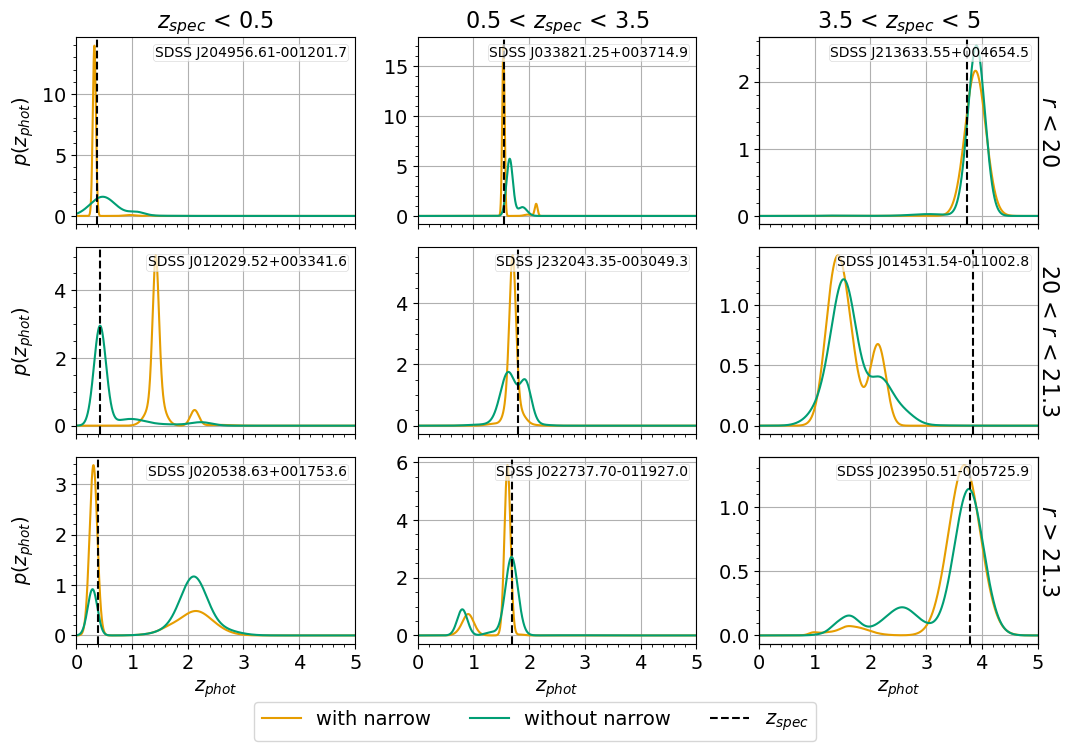

In [7]:
PDF_Sample(models_bnn['with narrow'], pdfs_bnn_noflag, x_bnn, 'PStotal', 47, '',
           False, False, True, True, idxs)

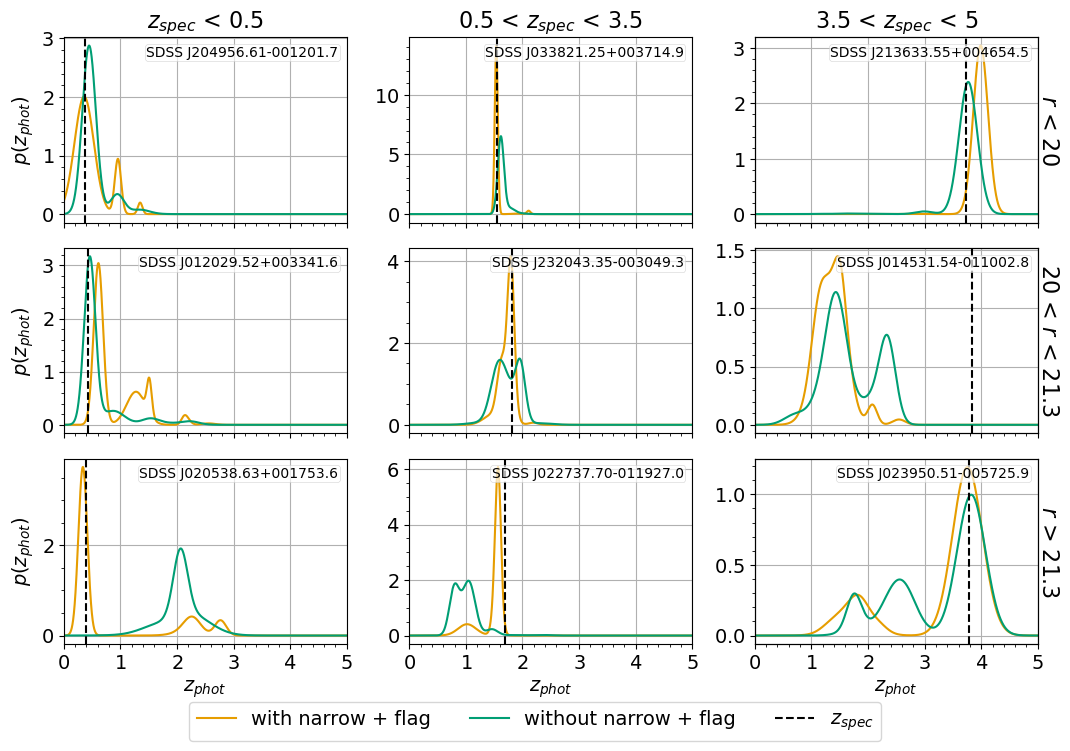

In [8]:
PDF_Sample(models_bnn['with narrow + flag'], pdfs_bnn_flag, x_bnn, 'PStotal', 47, '',
           False, False, True, True, idxs)

In [9]:
for k in list(pdfs_bnn.keys()):
    print(k, round(CDE(x_bnn, models_bnn[k]['z'].values, pdfs_bnn[k]), 4))

with narrow -2.7054
with narrow + flag -2.7078
without narrow -1.3018
without narrow + flag -1.283


## FlexCoDE

In [10]:
x_flex = pd.read_csv(os.path.join(flex_path, 'z_grid.csv'), usecols=['x']).x.values
models_flex = {
    'with narrow': pd.read_csv(os.path.join(flex_path, 'test_z_broadGALEXWISEnarrowflags.csv')),
    'without narrow': pd.read_csv(os.path.join(flex_path, 'test_z_broadGALEXWISEflags.csv'))
    }

pdfs_flex = {}
for name, table in models_flex.items():
    pdfs_list = []
    for i in range(len(table)):
        pdfs_list.append(table.loc[i, [f'z_flex_pdf_{i}' for i in range(1, 201)]].values)
    pdfs_flex[name] = np.array(pdfs_list)

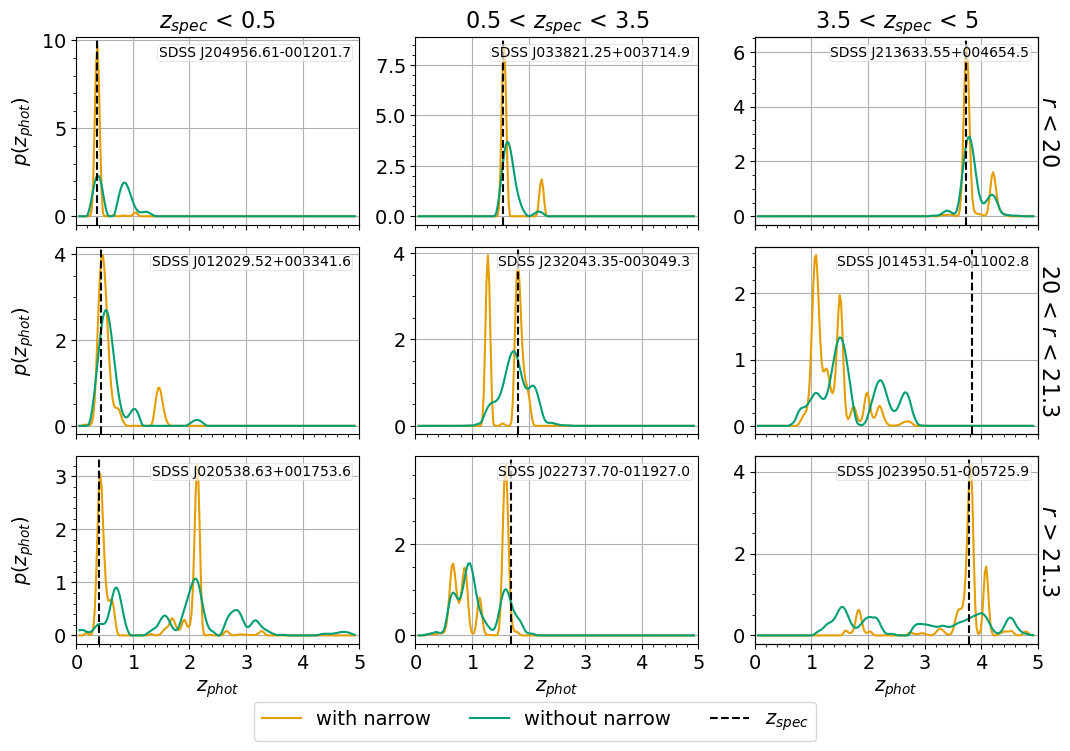

In [11]:
PDF_Sample(pd.concat([models_flex['with narrow'], models_bnn['with narrow'][['z', 'r_PStotal', 'SDSS_NAME']]], axis=1),
           pdfs_flex, x_flex, 'PStotal', 47, '', False, False, True, True, idxs)

In [12]:
for k in list(pdfs_flex.keys()):
    print(k, round(CDE(x_flex, models_bnn[k]['z'].values, pdfs_flex[k]), 4))

with narrow -3.0309
without narrow -1.3596
